In [ ]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForQuestionAnswering
import time

In [ ]:
pip install transformers

In [ ]:
is_cuda = torch.cuda.is_available()


if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
%%capture
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O squad/train-v1.1.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json -O squad/dev-v1.1.json


In [ ]:
#Step 2: Retrieve and Store the data
# Define the path to the SQuAD 2.0 training data
path = "/content/squad/train-v1.1.json"

# Load and preprocess the SQuAD 2.0 data
def load_squad_data(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []

    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    texts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return texts, questions, answers

# Preprocess the data to find answer start and end positions
train_texts, train_queries, train_answers = load_squad_data(path)

In [ ]:
# Give the path for SQuAD 2.0 validation data
path = Path('/content/squad/dev-v1.1.json')

# Load and preprocess the SQuAD 2.0 data
def load_squad_data(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []

    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    texts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return texts, questions, answers

# Preprocess the data to find answer start and end positions
val_texts, val_queries, val_answers = load_squad_data(path)

In [ ]:
#Step 3: Check the data
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

87599
87599
87599


In [ ]:
print("Passage: ",train_texts[0])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Query:  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer:  {'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}


In [ ]:

print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

34726
34726
34726


In [ ]:

print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Query:  Which NFL team represented the AFC at Super Bowl 50?
Answer:  {'answer_start': 177, 'text': 'Denver Broncos'}


In [ ]:
#	Step 4: Find the start and end position character
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
#Step 5: Tokenize passages and queries

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

In [ ]:
#	Step 6: Convert the start-end positions to tokens start-end positions
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []

    count = 0

    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length

        # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)

            # if end position is still None the answer passage has been truncated
            if end_positions[-1] is None:
                count += 1
                end_positions[-1] = tokenizer.model_max_length
    print(count)

    # Update the data in dictionary
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

10
23


In [ ]:
#Step 7: Create a Dataset class
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
#Step 8: Use of DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [ ]:
#Step 9: Use GPU
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [ ]:
#Step 10: Build the Bert model

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AdamW
optim = AdamW(model.parameters(), lr=5e-5)

epochs = 3

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#	Step 11: Train and Evaluate Model
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 100

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()
    loss_of_epoch = 0

    print("############Train############")

    for batch_idx,batch in enumerate(train_loader):
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # do a backwards pass
        loss.backward()
        # update the weights
        optim.step()
        # Find the total loss
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ##########Evaluation##################

    # Set model in evaluation mode
    model.eval()

    print("############Evaluate############")

    loss_of_epoch = 0

    for batch_idx,batch in enumerate(val_loader):

        with torch.no_grad():

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Find the total loss
            loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    # Print each epoch's time and train/val loss

    print("\n-------Epoch ", epoch+1,
          "-------"
          "\nTraining Loss:", train_losses[-1],
          "\nValidation Loss:", val_losses[-1],
          "\nTime: ",(time.time() - epoch_time),
          "\n-----------------------",
          "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 100 / 5475 
Loss: 3.4 

Batch 200 / 5475 
Loss: 2.2 

Batch 300 / 5475 
Loss: 2.2 

Batch 400 / 5475 
Loss: 1.0 

Batch 500 / 5475 
Loss: 0.9 

Batch 600 / 5475 
Loss: 1.1 

Batch 700 / 5475 
Loss: 1.0 

Batch 800 / 5475 
Loss: 1.3 

Batch 900 / 5475 
Loss: 1.3 

Batch 1000 / 5475 
Loss: 1.3 

Batch 1100 / 5475 
Loss: 1.2 

Batch 1200 / 5475 
Loss: 1.2 

Batch 1300 / 5475 
Loss: 1.7 

Batch 1400 / 5475 
Loss: 1.0 

Batch 1500 / 5475 
Loss: 1.1 

Batch 1600 / 5475 
Loss: 1.5 

Batch 1700 / 5475 
Loss: 1.5 

Batch 1800 / 5475 
Loss: 0.8 

Batch 1900 / 5475 
Loss: 0.9 

Batch 2000 / 5475 
Loss: 1.2 

Batch 2100 / 5475 
Loss: 1.0 

Batch 2200 / 5475 
Loss: 1.3 

Batch 2300 / 5475 
Loss: 1.1 

Batch 2400 / 5475 
Loss: 1.7 

Batch 2500 / 5475 
Loss: 0.8 

Batch 2600 / 5475 
Loss: 0.6 

Batch 2700 / 5475 
Loss: 0.8 

Batch 2800 / 5475 
Loss: 0.6 

Batch 2900 / 5475 
Loss: 1.3 

Batch 3000 / 5475 
Loss: 1.1 

Batch 3100 / 5475 
Loss: 1.1 

Batch 3200 / 5475 

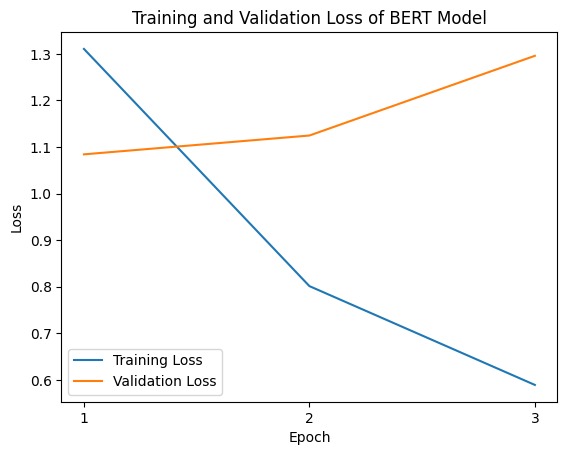

In [ ]:
import matplotlib.pyplot as plt

# Plotting validation loss versus training loss
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, len(train_losses) + 1))  # Set x-ticks to integer values
    plt.title('Training and Validation Loss of BERT Model')
    plt.legend()
    plt.show()

# Assuming train_losses and val_losses are lists containing training and validation losses for each epoch
plot_loss(train_losses, val_losses)


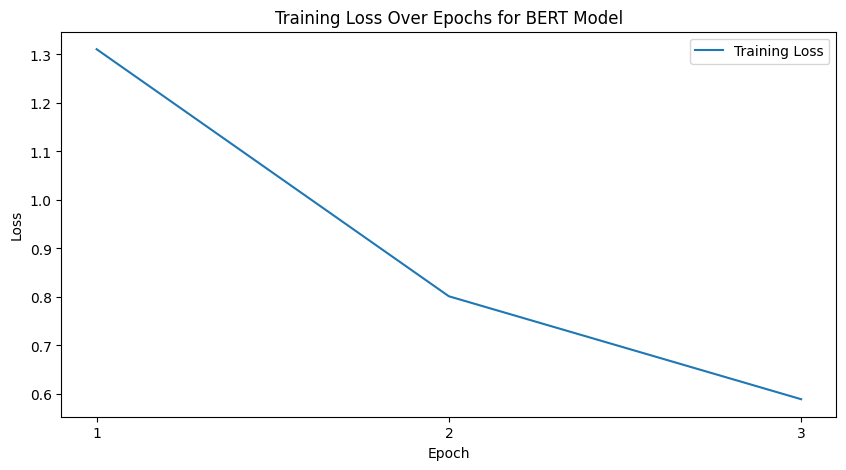

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xticks(range(1, epochs + 1))  # Set x-axis ticks to 1, 2, 3, ...
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for BERT Model')
plt.legend()
plt.show()


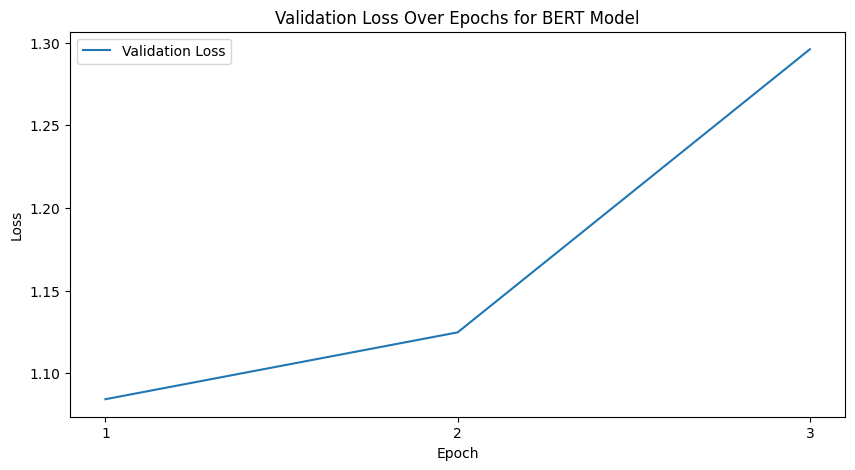

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xticks(range(1, epochs + 1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs for BERT Model')
plt.legend()
plt.show()


In [ ]:
#Step 13: Save trained model
import os

# Define the path where you want to save the model
save_path = '/content/drive/MyDrive/Sandesh/BERT Model for QA system'

# Create the directory if it does not exist
os.makedirs(save_path, exist_ok=True)

# Specify the filename for the model
filename = 'bert_finetunedmodel.pt'

# Save the model
torch.save(model.state_dict(), os.path.join(save_path, filename))


In [ ]:
# Load the model architecture
from transformers import BertForQuestionAnswering, BertTokenizer


# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

# Load the state dictionary
model.load_state_dict(torch.load('/content/drive/MyDrive/Sandesh/BERT Model for QA system/bert_finetunedmodel.pt', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'torch' is not defined

In [ ]:
# Make the prediction and evaluate it
def predict(context, query):
    inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
    outputs = model(**inputs)
    answer_start = torch.argmax(outputs.start_logits)  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(outputs.end_logits) + 1
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    return 2 * (prec * rec) / (prec + rec)

In [ ]:
def give_an_answer(context, query, answer):
    prediction = predict(context, query)
    em_score = compute_exact_match(prediction, answer)
    f1_score = compute_f1(prediction, answer)
    print(f"Question: {query}")
    print(f"Prediction: {prediction}")
    print(f"True Answer: {answer}")
    print(f"EM: {em_score}")
    print(f"F1: {f1_score}")
    print("\n")

In [ ]:
context = """ Queen are a British rock band formed in London in 1970. Their classic line-up was Freddie Mercury (lead vocals, piano),
            Brian May (guitar, vocals), Roger Taylor (drums, vocals) and John Deacon (bass). Their earliest works were influenced
            by progressive rock, hard rock and heavy metal, but the band gradually ventured into more conventional and radio-friendly
            works by incorporating further styles, such as arena rock and pop rock. """

queries = ["When did Queen found?",
           "Who were the basic members of Queen band?",
           "What kind of band they are?"
          ]
answers = ["1970",
           "Freddie Mercury, Brian May, Roger Taylor and John Deacon",
           "rock"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: When did Queen found?
Prediction: 1970.
True Answer: 1970
EM: 1
F1: 1.0


Question: Who were the basic members of Queen band?
Prediction: freddie mercury ( lead vocals, piano ), brian may ( guitar, vocals ), roger taylor ( drums, vocals ) and john deacon ( bass ).
True Answer: Freddie Mercury, Brian May, Roger Taylor and John Deacon
EM: 0
F1: 0.6923076923076924


Question: What kind of band they are?
Prediction: 
True Answer: rock
EM: 0
F1: 0




In [ ]:
context = """ The COVID-19 pandemic, also known as the coronavirus pandemic, is an ongoing pandemic of coronavirus disease 2019 (COVID-19)
              caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, China.
              The World Health Organization declared the outbreak a Public Health Emergency of International Concern in January 2020 and a pandemic
              in March 2020. As of 6 February 2021, more than 105 million cases have been confirmed, with more than 2.3 million deaths attributed to COVID-19.
              Symptoms of COVID-19 are highly variable, ranging from none to severe illness. The virus spreads mainly through the air when people are
              near each other.[b] It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes.
              It may also spread via contaminated surfaces. People remain infectious for up to two weeks, and can spread the virus even if they do not show symptoms.[9]"""

queries = [
           "What is COVID-19?",
           "What is caused by COVID-19?",
           "How many cases have been confirmed from COVID-19?",
           "How many deaths have been confirmed from COVID-19?",
           "How is COVID-19 spread?",
           "How long can an infected person remain infected?",
           "Can a infected person spread the virus even if they don't have symptoms?",
           "What do elephants eat?"
          ]
answers = [
           "an ongoing pandemic of coronavirus disease 2019",
           "severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)",
           "more than 105 million cases",
           "more than 2.3 million deaths",
           "mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.",
           "up to two weeks",
           "yes",
           " "
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: What is COVID-19?
Prediction: coronavirus disease 2019
True Answer: an ongoing pandemic of coronavirus disease 2019
EM: 0
F1: 0.6666666666666666


Question: What is caused by COVID-19?
Prediction: severe acute respiratory syndrome coronavirus 2 ( sars - cov - 2 ).
True Answer: severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)
EM: 0
F1: 0.75


Question: How many cases have been confirmed from COVID-19?
Prediction: 105 million cases
True Answer: more than 105 million cases
EM: 0
F1: 0.7499999999999999


Question: How many deaths have been confirmed from COVID-19?
Prediction: 2. 3 million
True Answer: more than 2.3 million deaths
EM: 0
F1: 0.25


Question: How is COVID-19 spread?
Prediction: the virus spreads mainly through the air when people are near each other.
True Answer: mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may als

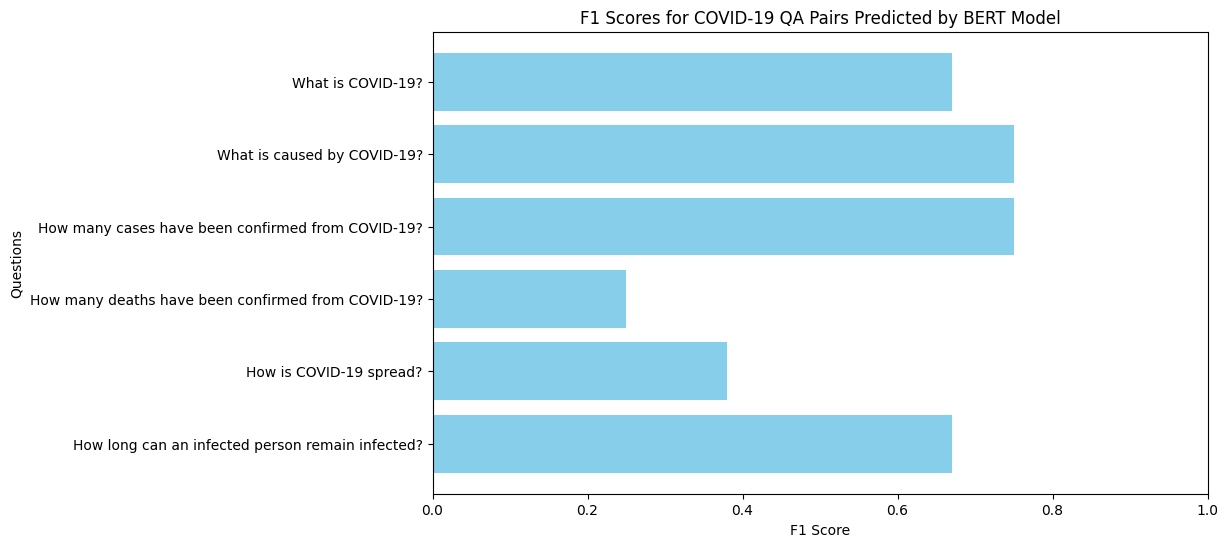

In [ ]:
import matplotlib.pyplot as plt

def plot_f1_scores(questions, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.barh(questions, f1_scores, color='skyblue')
    plt.xlabel('F1 Score')
    plt.ylabel('Questions')
    plt.title('F1 Scores for COVID-19 QA Pairs Predicted by BERT Model')
    plt.xlim(0, 1)  # Set the x-axis limit from 0 to 1
    plt.gca().invert_yaxis()  # Invert y-axis to display questions from top to bottom
    plt.show()

# Example data
questions = ['What is COVID-19?', 'What is caused by COVID-19?',
             'How many cases have been confirmed from COVID-19?',
             'How many deaths have been confirmed from COVID-19?',
             'How is COVID-19 spread?', 'How long can an infected person remain infected?']
f1_scores = [0.67, 0.75, 0.75, 0.25, 0.38, 0.67]  # F1 scores corresponding to each question

plot_f1_scores(questions, f1_scores)


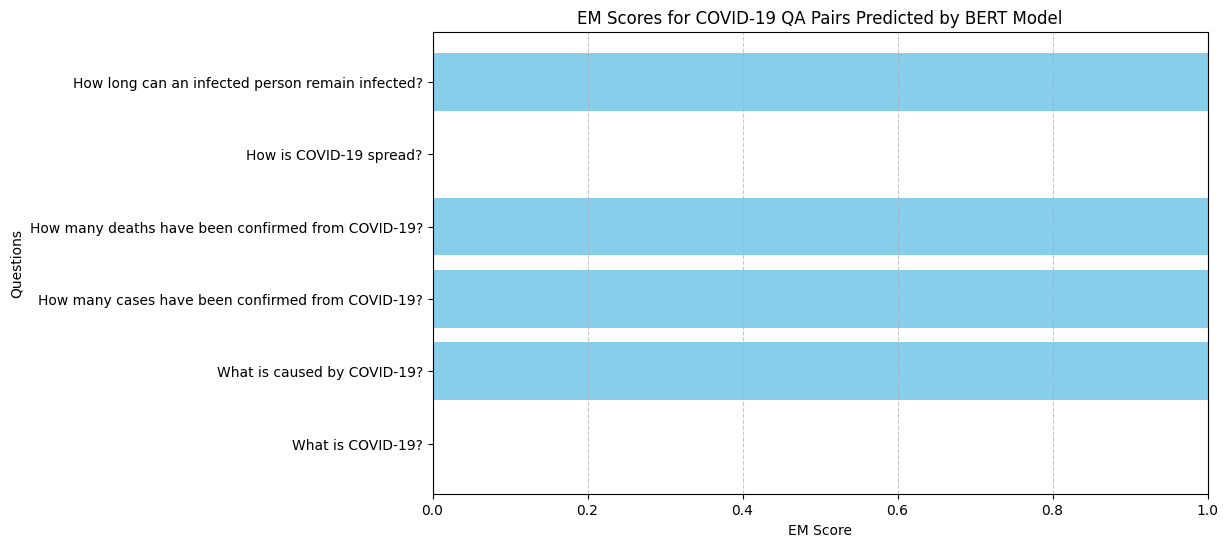

In [ ]:
import matplotlib.pyplot as plt

# EM scores for each question-answer pair
em_scores = [0, 1, 1, 1, 0, 1]  # EM scores corresponding to each question

# Questions corresponding to each score
questions = [
    "What is COVID-19?",
    "What is caused by COVID-19?",
    "How many cases have been confirmed from COVID-19?",
    "How many deaths have been confirmed from COVID-19?",
    "How is COVID-19 spread?",
    "How long can an infected person remain infected?"
]

# Plot EM scores
plt.figure(figsize=(10, 6))
plt.barh(questions, em_scores, color='skyblue')
plt.xlabel('EM Score')
plt.ylabel('Questions')
plt.title('EM Scores for COVID-19 QA Pairs Predicted by BERT Model')
plt.xlim(0, 1)  # Limit EM score to range [0, 1]
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


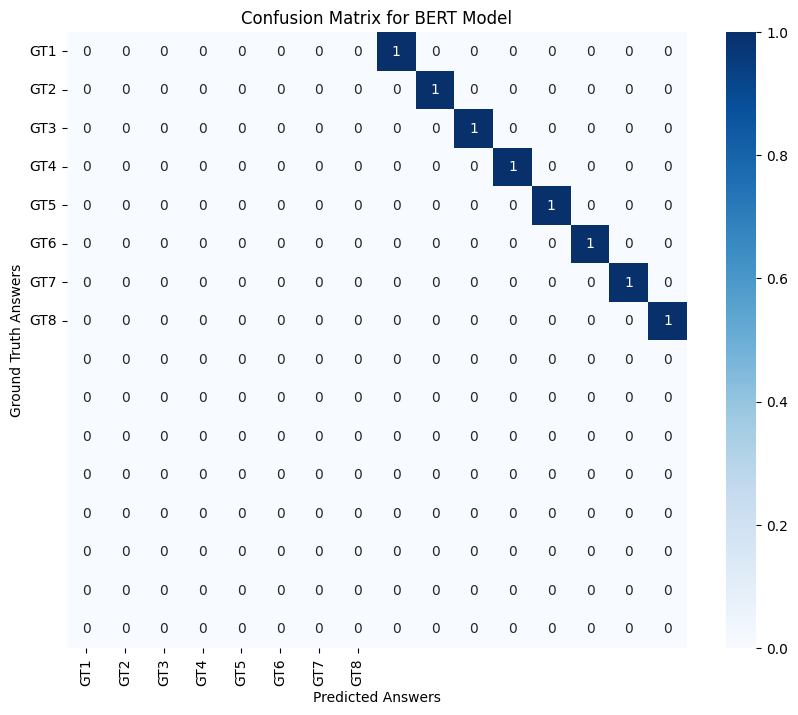

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ground truth answers
ground_truth = [
    "GT1",
    "GT2",
    "GT3",
    "GT4",
    "GT5",
    "GT6",
    "GT7",
    "GT8"
]

# Predicted answers
predicted_answers = [
    "PA1",
    "PA2",
    "PA3",
    "PA4",
    "PA5",
    "PA6",
    "PA7",
    "PA8"
]

# Generate confusion matrix
conf_matrix = confusion_matrix(ground_truth, predicted_answers)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=ground_truth, yticklabels=ground_truth)
plt.xlabel('Predicted Answers')
plt.ylabel('Ground Truth Answers')
plt.title('Confusion Matrix for BERT Model')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [ ]:
_context = """ Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard,
              Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry.
              The main story arc concerns Harry's struggle against Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard
              governing body known as the Ministry of Magic and subjugate all wizards and Muggles (non-magical people). Since the release of the first novel,
              Harry Potter and the Philosopher's Stone, on 26 June 1997, the books have found immense popularity, positive reviews, and commercial success worldwide.
              They have attracted a wide adult audience as well as younger readers and are often considered cornerstones of modern young adult literature.[2]
              As of February 2018, the books have sold more than 500 million copies worldwide, making them the best-selling book series in history, and have been translated
              into eighty languages.[3] The last four books consecutively set records as the fastest-selling books in history, with the final installment selling roughly
              eleven million copies in the United States within twenty-four hours of its release.  """

queries = [
           "Who wrote Harry Potter's novels?",
           "Who are Harry Potter's friends?",
           "Who is the enemy of Harry Potter?",
           "What are Muggles?",
           "Which is the name of Harry Poter's first novel?",
           "When did the first novel release?",
           "Who was attracted by Harry Potter novels?",
           "How many languages Harry Potter has been translated into? "
          ]
answers = [
           "J. K. Rowling",
           "Hermione Granger and Ron Weasley",
           "Lord Voldemort",
           "non-magical people",
           "Harry Potter and the Philosopher's Stone",
           "26 June 1997",
           "a wide adult audience as well as younger readers",
           "eighty"
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: Who wrote Harry Potter's novels?
Prediction: j. k. rowling.
True Answer: J. K. Rowling
EM: 1
F1: 1.0


Question: Who are Harry Potter's friends?
Prediction: hermione granger and ron weasley,
True Answer: Hermione Granger and Ron Weasley
EM: 1
F1: 1.0


Question: Who is the enemy of Harry Potter?
Prediction: harry potter,
True Answer: Lord Voldemort
EM: 0
F1: 0


Question: What are Muggles?
Prediction: non - magical people )
True Answer: non-magical people
EM: 0
F1: 0.4


Question: Which is the name of Harry Poter's first novel?
Prediction: harry potter and the philosopher ' s stone,
True Answer: Harry Potter and the Philosopher's Stone
EM: 0
F1: 0.7272727272727272


Question: When did the first novel release?
Prediction: 26 june 1997,
True Answer: 26 June 1997
EM: 1
F1: 1.0


Question: Who was attracted by Harry Potter novels?
Prediction: j. k. rowling.
True Answer: a wide adult audience as well as younger readers
EM: 0
F1: 0


Question: How many languages Harry Potter has be

In [ ]:
#	Step 17: Test pretrained BERT model
# Define the bert tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Load the fine-tuned modeol
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.eval()

NameError: name 'AutoTokenizer' is not defined

In [ ]:
def predict(context,query):

    inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
    outputs = model(**inputs)
    answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(outputs[1]) + 1
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    return 2 * (prec * rec) / (prec + rec)

In [ ]:
def give_an_answer(context,query,answer):
    prediction = predict(context,query)
    em_score = compute_exact_match(prediction, answer)
    f1_score = compute_f1(prediction, answer)
    print(f"Question: {query}")
    print(f"Prediction: {prediction}")
    print(f"True Answer: {answer}")
    print(f"EM: {em_score}")
    print(f"F1: {f1_score}")
    print("\n")

In [ ]:
context = "Hi! My name is Alexa and I am 21 years old. I used to live in Peristeri of Athens, but now I moved on in Kaisariani of Athens."

queries = ["How old is Alexa?",
           "Where does Alexa live now?",
           "Where Alexa used to live?"
          ]
answers = ["21",
           "Kaisariani of Athens",
           "Peristeri of Athens"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: How old is Alexa?
Prediction: 21
True Answer: 21
EM: 1
F1: 1.0


Question: Where does Alexa live now?
Prediction: kaisariani of athens
True Answer: Kaisariani of Athens
EM: 1
F1: 1.0


Question: Where Alexa used to live?
Prediction: peristeri of athens
True Answer: Peristeri of Athens
EM: 1
F1: 1.0




In [ ]:
context = """ Queen are a British rock band formed in London in 1970. Their classic line-up was Freddie Mercury (lead vocals, piano),
            Brian May (guitar, vocals), Roger Taylor (drums, vocals) and John Deacon (bass). Their earliest works were influenced
            by progressive rock, hard rock and heavy metal, but the band gradually ventured into more conventional and radio-friendly
            works by incorporating further styles, such as arena rock and pop rock. """

queries = ["When did Queen found?",
           "Who were the basic members of Queen band?",
           "What kind of band they are?"
          ]
answers = ["1970",
           "Freddie Mercury, Brian May, Roger Taylor and John Deacon",
           "rock"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: When did Queen found?
Prediction: 1970
True Answer: 1970
EM: 1
F1: 1.0


Question: Who were the basic members of Queen band?
Prediction: freddie mercury ( lead vocals, piano ), brian may ( guitar, vocals ), roger taylor ( drums, vocals ) and john deacon ( bass )
True Answer: Freddie Mercury, Brian May, Roger Taylor and John Deacon
EM: 0
F1: 0.6923076923076924


Question: What kind of band they are?
Prediction: british rock
True Answer: rock
EM: 0
F1: 0.6666666666666666


